In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# http://bjlkeng.github.io/posts/the-expectation-maximization-algorithm/

In [2]:
np.random.seed(36817)
p_n = stats.binom(40, 0.5)
k1 = np.random.multivariate_normal([0, 0], np.array([[1, -0.5], [-0.5, 1]]), p_n.rvs())

k2 = np.random.multivariate_normal([9, -1], np.array([[1, 0.1], [0.1, 1]]), p_n.rvs())

k3 = np.random.multivariate_normal([-8, 0.3], np.array([[1, 0.9], [0.9, 1]]), p_n.rvs())

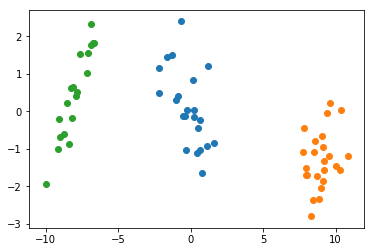

In [3]:
plt.scatter(k1[:, 0], k1[:, 1])
plt.scatter(k2[:, 0], k2[:, 1])
plt.scatter(k3[:, 0], k3[:, 1])

# Gaussian mixture
Assume there is $\pi$ probability of a data point coming from one of $K$ clusters.

$$ z_i \sim Categorical(\pi) $$

$$ x_i|z_i \sim N(\mu_k, \sigma_k^2) $$
$$ p(x_i|\theta) = \sum_{k=1}^Kp(z_i=k) \cdot p(x_i|z_i=k, \mu_k, \sigma_k^2)$$

## maximization step
$$ \pi_k = \frac{1}{N}\sum_i p(z_i = k| x_i, \theta)$$
$$ \mu_k = \frac{\sum_i p(z_i = k| x_i, \theta) x_i}{\sum_i p(z_i = k| x_i, \theta)}$$
$$ cov_k = \frac{\sum_i p(z_i = k| x_i, \theta) \cdot (x_i - \mu_k)(y_i - \mu_k)}{\sum_i p(z_i = k| x_i, \theta)}$$

In [4]:
data = np.vstack([k1, k2, k3])

[0.33846154 0.36923077 0.29230769]


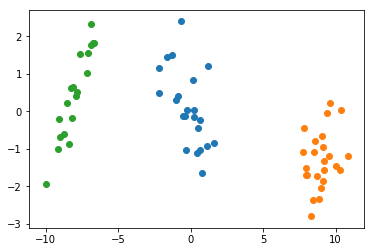

In [493]:
def weighted_covariance(x, y, likelihoods, mu_k):
    return np.sum(likelihoods * (x - mu_k[0]) * (y - mu_k[1])) / likelihoods.sum()

class EM:
    def __init__(self, k):
        self.k = k
        self.z = np.arange(k)
        self.mu = np.random.choice(data.flatten(), k * 2).reshape((k, 2))  # 2 dimensional
        self.cov = np.stack([np.array([[1., 0.], [0., 1.]]) for _ in range(k)])
        self.pi = np.ones(k) / k
        self.log_likelihoods = None
        
    def expectation_step(self, x):
        for z_i in self.z:
            mu_i = self.mu[z_i]
            cov_i = self.cov[z_i]
            self.log_likelihoods[z_i, :] = self.pi[z_i] + stats.multivariate_normal(mu_i, cov_i).logpdf(x)
        # normalize by marginalizing K
        self.log_likelihoods = self.log_likelihoods - np.log(np.exp(self.log_likelihoods).sum(0))
    
    def maximization_step(self, x):
        for z_i in self.z:
            likelihoods = np.exp(self.log_likelihoods[z_i])
            # weighted average
            self.mu[z_i] = ((x * likelihoods[:, None]) / likelihoods.sum()).sum(0)
            
            # weighted variance
            cov = weighted_covariance(x[:, 0], x[:, 1], likelihoods, self.mu[z_i])
                       
            cov = np.array([[weighted_covariance(x[:, 0], x[:, 0], likelihoods, self.mu[z_i]), cov],
                                     [cov, weighted_covariance(x[:, 1], x[:, 1], likelihoods, self.mu[z_i])]])
            
            if np.all(np.linalg.eigvals(cov) > 0) and (1e-6 < np.linalg.det(cov)):
                self.cov[z_i] = cov
                
            # weighted pi
            self.pi[z_i] = likelihoods.sum() / x.shape[0]
            
    def fit(self, x):
        self.log_likelihoods = np.zeros((self.k, x.shape[0]))
        last_log_likelihood = np.inf
        while np.abs(self.log_likelihoods.sum() - last_log_likelihood) > 0.01:
            last_log_likelihood = self.log_likelihoods.sum()
            self.expectation_step(x)
            self.maximization_step(x)
                
    def predict(self, x):
        log_likelihoods = np.zeros((self.k, x.shape[0]))
        for z_i in self.z:
            mu_i = self.mu[z_i]
            cov_i = self.cov[z_i]
            log_likelihoods[z_i, :] = self.pi[z_i] + stats.multivariate_normal(mu_i, cov_i).logpdf(x)
        return log_likelihoods.argmax(0)
            
m = EM(3)
m.fit(data)
y = m.predict(data)

mask = y == 0
plt.scatter(data[mask][:, 0], data[mask][:, 1])
mask = y == 1
plt.scatter(data[mask][:, 0], data[mask][:, 1])
mask = y == 2
plt.scatter(data[mask][:, 0], data[mask][:, 1])
